## Tutorial on chemical reaction network (CRN) inference

Dependecies: `Catalyst, OrdinaryDiffEq, CairoMakie, Optim, LineSearches`

### Simulating a CRN

Fisrt, we simulate a synthetic dataset based on the following CRN, i.e. our ground-truth CRN:
$$ X_1\xrightarrow[]{k_{1}}X_2, \qquad X_1+X_2\xrightleftharpoons[k_{13}]{k_{18}}X_3.$$
The subscripts of the reaction rate constants will be explained later when we introduce the library CRN.

The `@reaction_network` macro from `Catalyst.jl` enables us to programatically define CRNs. Note that package imports and first calls to functions take longer times to run due to compilation.

In [1]:
using Catalyst

In [2]:
true_crn = @reaction_network begin
	k₁, X₁ --> X₂                # unidirectional reaction
	(k₁₈, k₁₃), X₁ + X₂ <--> X₃	 # birectional reaction
end

Model ##ReactionSystem#236:
Unknowns (3): see unknowns(##ReactionSystem#236)
  X₁(t)
  X₂(t)
  X₃(t)
Parameters (3): see parameters(##ReactionSystem#236)
  k₁
  k₁₈
  k₁₃

`Catalyst.jl` features functionality to automatically derive the corresponding ordinary differential equation (ODE) system (assuming mass-action kinetics).

In [3]:
convert(ODESystem, true_crn)

Model ##ReactionSystem#236:
Equations (3):
  3 standard: see equations(##ReactionSystem#236)
Unknowns (3): see unknowns(##ReactionSystem#236)
  X₁(t)
  X₂(t)
  X₃(t)
Parameters (3): see parameters(##ReactionSystem#236)
  k₁
  k₁₈
  k₁₃

To simulate the dynamics of this ODE system, say over $t\in[0,10]$, we need to define and solve an `ODEProblem`. We will use the initial values $(X_1(0), X_2(0), X_3(0)) = (0,0,1)$ and set the reaction rate constants as $(k_{1},k_{13},k_{18})=(1,1,1)$.

In [4]:
using OrdinaryDiffEq

In [5]:
t_span = (0., 10.) # time interval to solve on
x0map = [:X₁ => 0., :X₂ => 0., :X₃ => 1.] # initial conditions
true_kmap  = (:k₁ => 1., :k₁₈ => 1., :k₁₃ => 1.) # ground-truth reaction rate constants

true_oprob = ODEProblem(true_crn, x0map, t_span, true_kmap)
true_sol = solve(true_oprob)

retcode: Success
Interpolation: 3rd order Hermite
t: 25-element Vector{Float64}:
  0.0
  0.0007064002045583837
  0.00777040225014222
  0.06315968433324934
  0.1928699846865976
  0.36423312918202805
  0.5615034713530583
  0.79145734935309
  1.0488720148516424
  1.3403529510999195
  1.669938434997888
  2.0510666649383342
  2.5207107293442714
  3.0564329842106215
  3.561926125860312
  4.13136698482351
  4.714760215275044
  5.346194682853374
  6.00429719846049
  6.700607279215679
  7.426351301223158
  8.183870090671803
  8.969223219783037
  9.780867179274527
 10.0
u: 25-element Vector{Vector{Float64}}:
 [0.0, 0.0, 1.0]
 [0.0007059012621207238, 0.000706400028394102, 0.9992938493547426]
 [0.00771010220425349, 0.007770168881821247, 0.9922598644569627]
 [0.0592164565262739, 0.06303905903105121, 0.9388722422213375]
 [0.15719382861586914, 0.18975048507473566, 0.8265278431546976]
 [0.2434421842392797, 0.3459354671217682, 0.7053111743194761]
 [0.2947382093072657, 0.5048311193098635, 0.600215335691

Next, we extract the ODE solution at 101 equally-spaced time points `t_obs`. Note that `true_sol(t_obs).u` is a vector of vectors; one vector per time point. We concatenate these vectors into a matrix; one column per time point.

In [6]:
n_obs = 101
t_obs = range(t_span..., n_obs)
data_noiseless = reduce(hcat, true_sol(t_obs).u)

3×101 Matrix{Float64}:
 0.0  0.0901911  0.16171   0.216322  …  0.0135083  0.0131308  0.0127647
 0.0  0.0995337  0.196541  0.28922      1.91539    1.91768    1.9199
 1.0  0.905138   0.820874  0.747229     0.0355485  0.0345941  0.0336656

To simulate noisy data, we introduce additive normal noise (independently and identically distributed) with standard deviation $\sigma=0.01$, and clamp the values to be nonnegative.

In [7]:
using Random
Random.seed!(1) # for reproducibility

σ = 0.01
data = data_noiseless .+ σ .* randn(size(data_noiseless)) # additive normal noise
data = max.(data, 0) # clamp negative values to 0

3×101 Matrix{Float64}:
 0.000619327  0.0906577  0.16347   …  0.0281459  0.0285949  0.00884948
 0.00278406   0.110392   0.205195     1.90582    1.91184    1.92575
 0.994042     0.889372   0.792972     0.0452687  0.0392716  0.0333524

We plot the noisy data along with the groud-truth trajectories.

In [8]:
# Plotting setup
using CairoMakie
using Colors
set_theme!(theme_latexfonts());
update_theme!(
	Axis=(;
		xgridvisible=false, ygridvisible=false,
		xlabelsize=16, ylabelsize=16,
		titlesize=16,
	),
)
palette = Makie.wong_colors();
lighten(c, w) = RGB((1 .- (1 .- [c.r, c.g, c.b]).*w)...); # lighten color c (w=0 gives white)

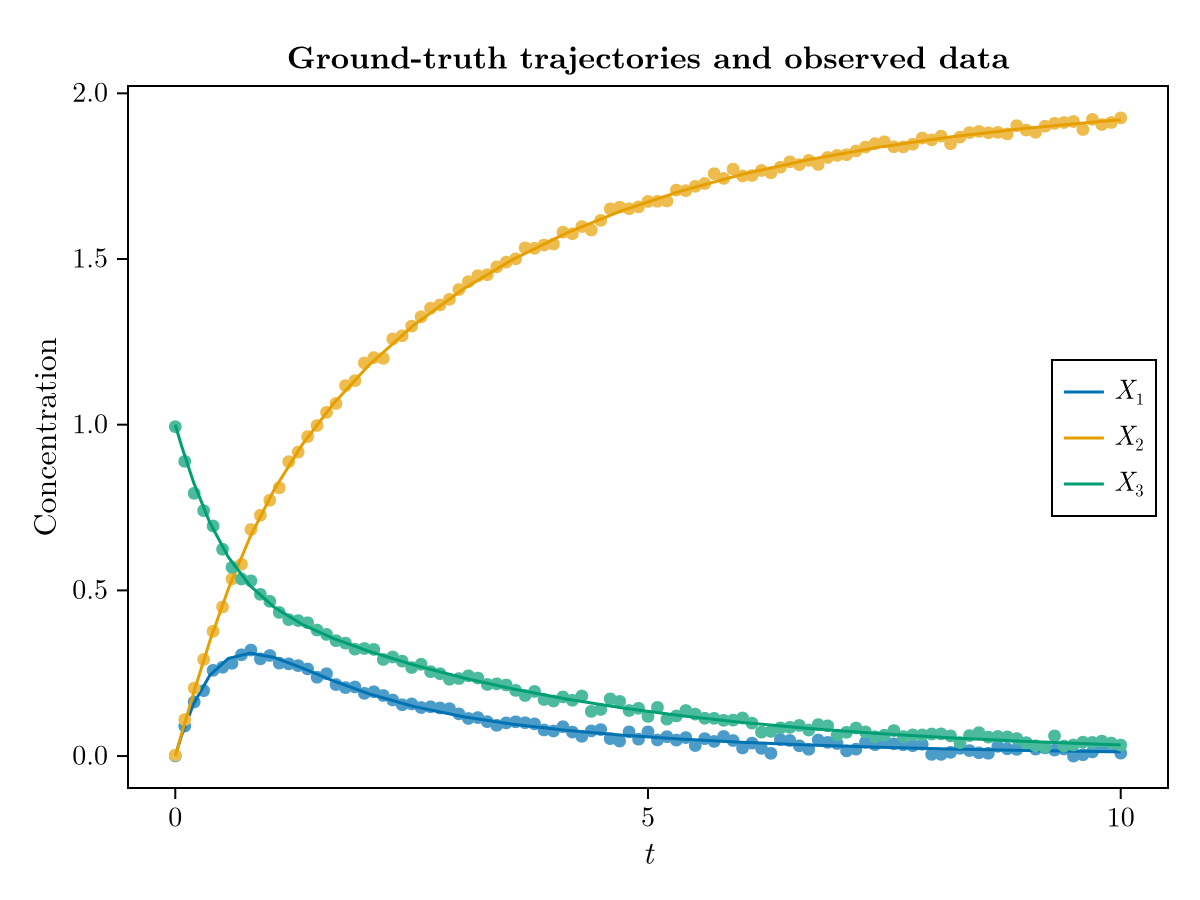

In [9]:
f = Figure()
ax = Axis(f[1,1], xlabel=L"t", ylabel="Concentration", title="Ground-truth trajectories and observed data")
n_species = size(data, 1)
for i in 1:n_species
    scatter!(t_obs, data[i,:], color=lighten(palette[i], 0.7))
    lines!(true_sol.t, [pt[i] for pt in true_sol.u], label=L"X_%$i")	
end
axislegend(position=:rc);
current_figure()

### Defining a library CRN

Given observed data and a set of candidate reactions, the problem of CRN inference is to deduce a subset of reactions that best explain the observed data. We call the CRN formed by all candidate reactions the *library CRN*. For this tutorial, the reactants and products of each reaction are one of the complexes $\{X_1,X_2,X_3,X_1+X_2,X_2+X_3,X_1+X_3\}$, and must be distinct. This results in $6\times 5=30$ candidate reactions. Instead of using the `@reaction_network` macro, here we [build a `ReactionSystem` programmatically](https://docs.sciml.ai/Catalyst/stable/model_creation/programmatic_CRN_construction/), which requires us to manually define the independent variable (time), the species, and the vector of reactions along with the rate constants as parameters.

In [10]:
t = default_t(); # time variable
xs = @species X₁(t) X₂(t) X₃(t)

complexes_vec = [xs[idx_vec] for idx_vec in [[1], [2], [3], [1, 2], [2, 3], [1, 3]]]; # all possible complexes
# define all ordered pairs of distinct complexes for reactions
rct_prd_pairs = [
	(reactants, products) for reactants in complexes_vec for products in complexes_vec 
	if reactants !== products
];
n_rx = length(rct_prd_pairs); # number of reactions
@parameters k[1:n_rx] # reaction rate constants
rx_vec = [
	Reaction(kval, reactants, products) for ((reactants, products), kval) in zip(rct_prd_pairs, k)
];

# CRN
@named lib_crn = ReactionSystem(rx_vec, t)
lib_crn = complete(lib_crn) # `lib_crn` is defined using the `ReactionSystem` constructor, and so has to be manually marked as complete

Model lib_crn:
Unknowns (3): see unknowns(lib_crn)
  X₁(t)
  X₂(t)
  X₃(t)
Parameters (30): see parameters(lib_crn)
  k[1]
  k[2]
  k[3]
  k[4]
  k[5]
  k[6]
  ⋮

Theoretically, the original CRN can be reconstructed from the library CRN using the ground-truth rate constants, with rate constants of irrelevant reactions set to zero. As a sanity check, we reconstruct the ground-truth trajectories using the library CRN.

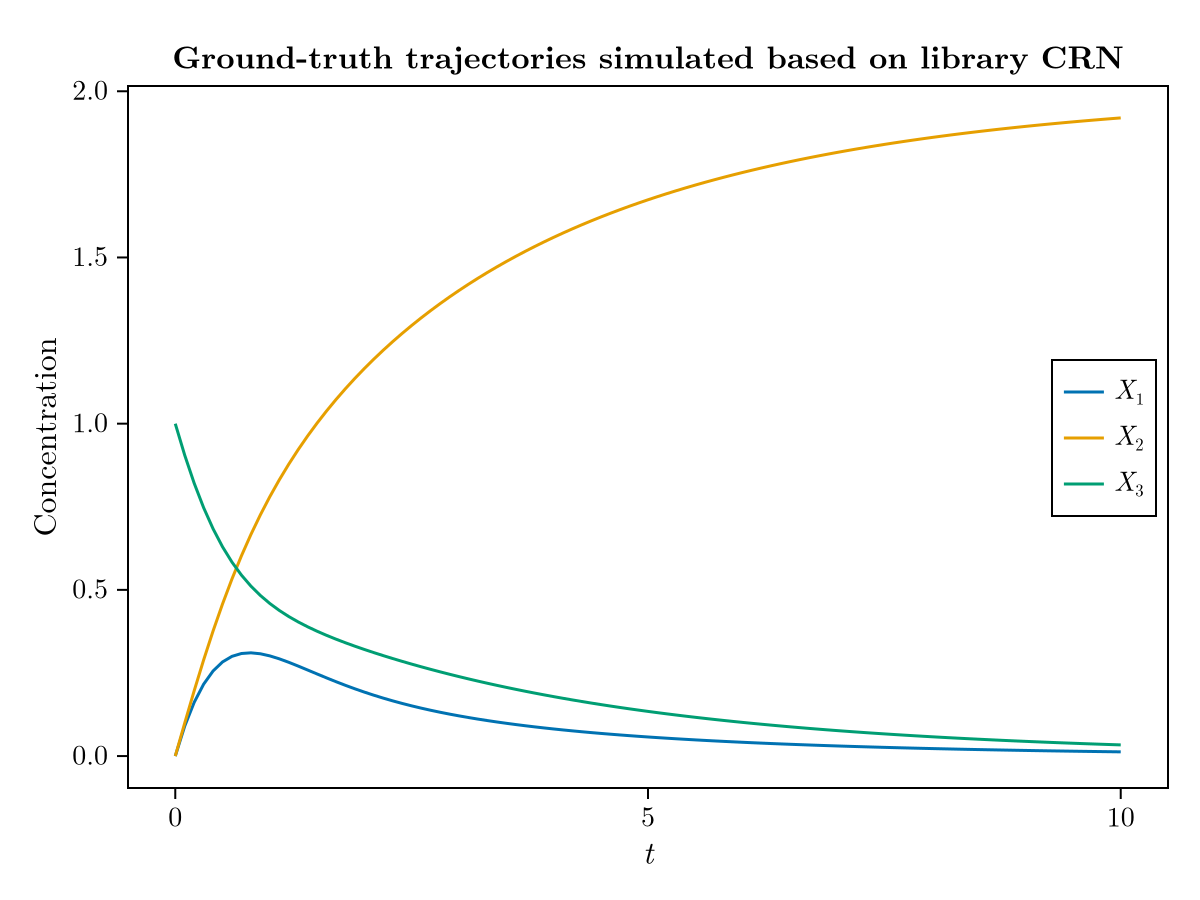

In [11]:
lib_oprob = ODEProblem(lib_crn, x0map, t_span, zeros(n_rx)) # `zeros(n_rx)` sets all rate constants to 0

true_kvec = zeros(n_rx); true_kvec[1] = 1; true_kvec[13] = 1; true_kvec[18] = 1; # ground-truth rate constants
check_oprob = remake(lib_oprob, p=[k => true_kvec]) # `p` is an argument name used by `remake`, `k` is the variable name defined along with the library CRN
check_sol = solve(check_oprob, saveat=0.1) # save solution every 0.1 units of time

f = Figure()
ax = Axis(f[1,1], xlabel=L"t", ylabel="Concentration", title="Ground-truth trajectories simulated based on library CRN")
for i in 1:n_species
    lines!(check_sol.t, [pt[i] for pt in check_sol.u], label=L"X_%$i")
end
axislegend(position=:rc);
current_figure()

### Parameter estimation

To estimate the rate constants from observed data, we 

### Reaction network inference

### Hyperparameter tuning

### Alternative penalty function